<a href="https://colab.research.google.com/github/vfrantc/quaternion_neurons/blob/main/quaternion_neuron.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip uninstall scikit-learn -y
!pip install -U scikit-learn
!pip install git+https://github.com/TParcollet/Quaternion-Neural-Networks.git

Found existing installation: scikit-learn 1.0.2
Uninstalling scikit-learn-1.0.2:
  Successfully uninstalled scikit-learn-1.0.2
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.8/9.8 MB 21.7 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/TParcollet/Quaternion-Neural-Networks.git to /tmp/pip-req-build-rrw0gl5l
  Running command git clone --filter=blob:none --quiet https://github.com/TParcollet/Quaternion-Neural-Networks.git /tmp/pip-req-build-rrw0gl5l
  Resolved https://github.com/TParcollet/Quaternion-Neural-Networks.git to commit f8de5d5e5a3f9c694a0d62cffc64ec4ccdffd1bc
  Preparing metadata (setup.py) ... done
  Created wheel for Pytorch-QNN: filename=Pytorch_QNN-1-py3-none-any.whl size=21516 sha256=19c90677e1f6417ee8f6854dbbb6be23f10bcb2f2352b992df6d76b0d04087f6
  Stored in directory: /tmp/pi

In [23]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

plt.style.use('ggplot')

# MLP iris classification

In [24]:
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report

iris = load_iris()
X = iris['data']
y = iris['target']
names = iris['target_names']
feature_names = iris['feature_names']

In [25]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=2)

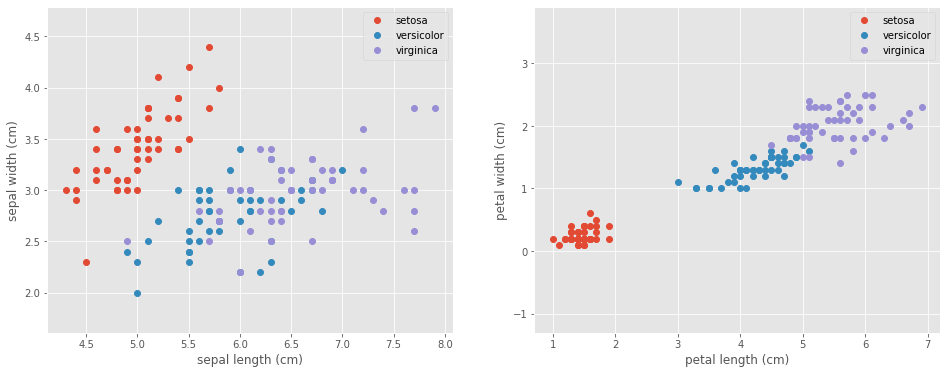

In [26]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
for target, target_name in enumerate(names):
    X_plot = X[y == target]
    ax1.plot(X_plot[:, 0], X_plot[:, 1], 
             linestyle='none', 
             marker='o', 
             label=target_name)
ax1.set_xlabel(feature_names[0])
ax1.set_ylabel(feature_names[1])
ax1.axis('equal')
ax1.legend();

for target, target_name in enumerate(names):
    X_plot = X[y == target]
    ax2.plot(X_plot[:, 2], X_plot[:, 3], 
             linestyle='none', 
             marker='o', 
             label=target_name)
ax2.set_xlabel(feature_names[2])
ax2.set_ylabel(feature_names[3])
ax2.axis('equal')
ax2.legend();

# Train MLP

In [27]:
import torch
import torch.nn.functional as F
import torch.nn as nn
from   torch.autograd import Variable

In [28]:
from core_qnn.quaternion_layers import QuaternionLinear

In [29]:
class Model(nn.Module):
    def __init__(self, input_dim):
        super(Model, self).__init__()
        self.layer1 = QuaternionLinear(input_dim, 32)
        self.layer2 = QuaternionLinear(32, 32)
        self.layer3 = QuaternionLinear(32, 4)
        
    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        x = F.softmax(self.layer3(x), dim=1)
        return x[:, 1:]

In [30]:
model     = Model(X_train.shape[1])
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss_fn   = nn.CrossEntropyLoss()
model

Model(
  (layer1): QuaternionLinear(in_features=1, out_features=8, bias=True, init_criterion=he, weight_init=quaternion, seed=946)
  (layer2): QuaternionLinear(in_features=8, out_features=8, bias=True, init_criterion=he, weight_init=quaternion, seed=1038)
  (layer3): QuaternionLinear(in_features=8, out_features=1, bias=True, init_criterion=he, weight_init=quaternion, seed=288)
)

In [31]:
import tqdm

EPOCHS  = 100
X_train = Variable(torch.from_numpy(X_train)).float()
y_train = Variable(torch.from_numpy(y_train)).long()
X_test  = Variable(torch.from_numpy(X_test)).float()
y_test  = Variable(torch.from_numpy(y_test)).long()

loss_list     = np.zeros((EPOCHS,))
accuracy_list = np.zeros((EPOCHS,))

for epoch in tqdm.trange(EPOCHS):
    y_pred = model(X_train)
    loss = loss_fn(y_pred, y_train)
    loss_list[epoch] = loss.item()
    
    # Zero gradients
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    with torch.no_grad():
        y_pred = model(X_test)
        correct = (torch.argmax(y_pred, dim=1) == y_test).type(torch.FloatTensor)
        accuracy_list[epoch] = correct.mean()

100%|██████████| 100/100 [00:00<00:00, 285.15it/s]


In [32]:
print(classification_report(y_test, np.argmax(y_pred.detach(), axis=1), labels=[0, 1, 2]))

              precision    recall  f1-score   support

           0       1.00      0.93      0.96        14
           1       0.86      0.75      0.80         8
           2       0.80      1.00      0.89         8

    accuracy                           0.90        30
   macro avg       0.89      0.89      0.88        30
weighted avg       0.91      0.90      0.90        30



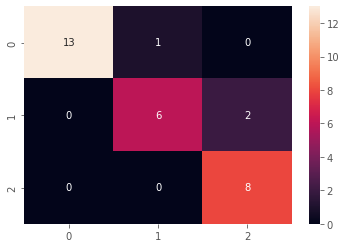

In [33]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
cf_matrix = confusion_matrix(y_test, np.argmax(y_pred.detach(), axis=1))
sns.heatmap(cf_matrix, annot=True)

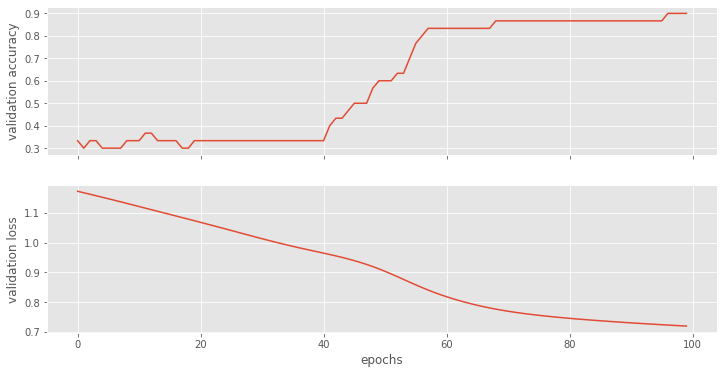

In [34]:
fig, (ax1, ax2) = plt.subplots(2, figsize=(12, 6), sharex=True)

ax1.plot(accuracy_list)
ax1.set_ylabel("validation accuracy")
ax2.plot(loss_list)
ax2.set_ylabel("validation loss")
ax2.set_xlabel("epochs");

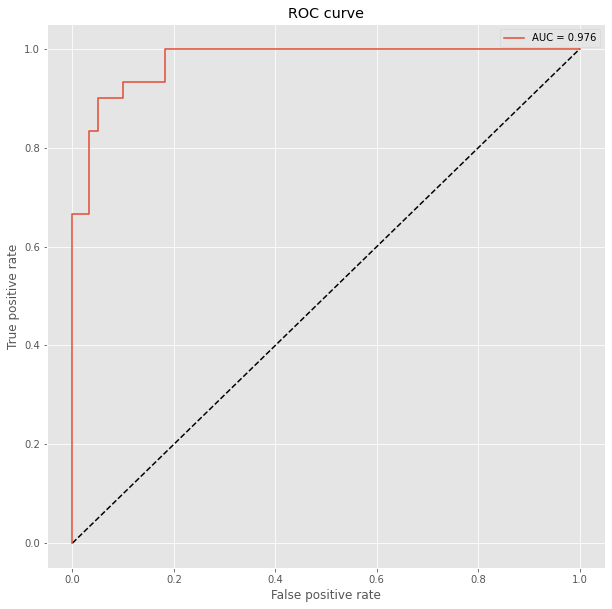

In [35]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import OneHotEncoder

plt.figure(figsize=(10, 10))
plt.plot([0, 1], [0, 1], 'k--')

# One hot encoding
enc = OneHotEncoder()
Y_onehot = enc.fit_transform(y_test[:, np.newaxis]).toarray()

with torch.no_grad():
    y_pred = model(X_test).numpy()
    fpr, tpr, threshold = roc_curve(Y_onehot.ravel(), y_pred.ravel())
    
plt.plot(fpr, tpr, label='AUC = {:.3f}'.format(auc(fpr, tpr)))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend();

# Decision boundaries

In [36]:
from sklearn.inspection import DecisionBoundaryDisplay

In [37]:
feature_1, feature_2, feature_3, feature_4 = np.meshgrid(
    np.linspace(X_scaled[:, 0].min(), X_scaled[:, 0].max()),
    np.linspace(X_scaled[:, 1].min(), X_scaled[:, 1].max()),
    np.linspace(X_scaled[:, 2].min(), X_scaled[:, 2].max()),
    np.linspace(X_scaled[:, 3].min(), X_scaled[:, 3].max())
)

grid = np.vstack([feature_1.ravel(), feature_2.ravel(), feature_3.ravel(), feature_4.ravel()]).T
grid = torch.tensor(grid, dtype=torch.float32)
prediction = model(grid).detach().numpy()
prediction = np.argmax(prediction, axis=1)

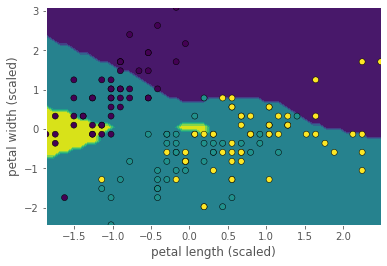

In [38]:
sl = 25
y_pred = np.reshape(prediction, feature_1.shape)
display = DecisionBoundaryDisplay(xx0=feature_1[:, :, sl, sl], xx1=feature_2[:, :, sl, sl], response=y_pred[:, :, sl, sl])
display.plot()
display.ax_.scatter(X_scaled[:, 0], X_scaled[:, 1], c=y, edgecolor="black")
display.ax_.set_xlabel('petal length (scaled)')
display.ax_.set_ylabel('petal width (scaled)')
plt.show()

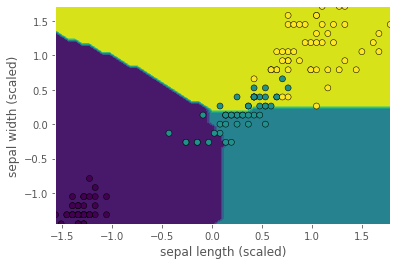

In [39]:
sl = 25
y_pred = np.reshape(prediction, feature_1.shape)
display = DecisionBoundaryDisplay(xx0=feature_3[sl, sl, :, :], xx1=feature_4[sl, sl, :, :], response=y_pred[sl, sl, :, :])
display.plot()
display.ax_.scatter(X_scaled[:, 2], X_scaled[:, 3], c=y, edgecolor="black")
display.ax_.set_xlabel('sepal length (scaled)')
display.ax_.set_ylabel('sepal width (scaled)')
plt.show()

# Convolution CIFAR10

In [ ]:
!git clone https://github.com/vfrantc/quaternion_conv.git

In [ ]:
%cd quaternion_conv/

In [ ]:
!pip install thop

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.backends.cudnn as cudnn
import torchvision
import torchvision.transforms as transforms

In [ ]:
import os
import sys
from tqdm.notebook import tqdm
from glob import glob

In [ ]:
from models import *

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
best_acc = 0  # best test accuracy
start_epoch = 0  # start from epoch 0 or last checkpoint epoch

In [ ]:
# Data
print('==> Preparing data..')
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

In [ ]:
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

In [ ]:
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=128, shuffle=True, num_workers=2)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=100, shuffle=False, num_workers=2)

In [ ]:
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

In [ ]:
# Model
print('==> Building model..')
net = ResNet18()
net = net.to(device)
if device == 'cuda':
    net = torch.nn.DataParallel(net)
    cudnn.benchmark = True

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9, weight_decay=5e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=200)

In [ ]:
def train(epoch):
    print('\nEpoch: %d' % epoch)
    net.train()
    train_loss = 0
    correct = 0
    total = 0
    for batch_idx, (inputs, targets) in enumerate(trainloader):
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()
        if batch_idx % 100 == 0:
          print(batch_idx, len(trainloader), 'Loss: %.3f | Acc: %.3f%% (%d/%d)' % (train_loss/(batch_idx+1), 100.*correct/total, correct, total))

In [ ]:
def test(epoch):
    global best_acc
    net.eval()
    test_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(testloader):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = net(inputs)
            loss = criterion(outputs, targets)

            test_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()

            print(batch_idx, len(testloader), 'Loss: %.3f | Acc: %.3f%% (%d/%d)' % (test_loss/(batch_idx+1), 100.*correct/total, correct, total))

    # Save checkpoint.
    acc = 100.*correct/total
    if acc > best_acc:
        print('Saving..')
        state = {
            'net': net.state_dict(),
            'acc': acc,
            'epoch': epoch,
        }
        if not os.path.isdir('checkpoint'):
            os.mkdir('checkpoint')
        torch.save(state, './checkpoint/ckpt.pth')
        best_acc = acc

In [ ]:
#for epoch in range(start_epoch, start_epoch+200):
for epoch in range(0, 2):
    train(epoch)
    test(epoch)
    scheduler.step()

# TSNE

In [ ]:
first_modules = list(net.children())
modules = list(first_modules[0].children())[:-1]
feature_net = nn.Sequential(*modules)
for p in net.parameters():
    p.requires_grad = False

In [ ]:
import numpy as np 
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from sklearn import manifold, datasets
from time import time

In [ ]:
features = []
for batch_idx, (inputs, targets) in tqdm(enumerate(testloader)):
    inputs, targets = inputs.to(device), targets.to(device)
    outputs = feature_net(inputs)
    outputs = F.avg_pool2d(outputs, 4)
    outputs = outputs.view(outputs.size(0), -1)
    outputs = outputs.cpu().numpy()
    features.append(outputs)
features = np.hstack(features)

In [ ]:
perplexity = 5
t0 = time()
tsne = manifold.TSNE(n_components=3, init="random", random_state=0, perplexity=perplexity, n_iter=300)
Y = tsne.fit_transform(features)
t1 = time()

In [ ]:
plt.figure()
plt.set_title("Perplexity=%d" % perplexity)
plt.scatter(Y[red, 0], Y[red, 1], c="r")
plt.scatter(Y[green, 0], Y[green, 1], c="g")
plt.xaxis.set_major_formatter(NullFormatter())
plt.yaxis.set_major_formatter(NullFormatter())
plt.axis("tight")